# Wafer Defect Detection

This notebook walks through the process of building and training a model to detect defects on semiconductor wafers.

## 1. Imports

Import all the necessary libraries.

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from scipy import interpolate

## 2. Model Definition

Here we define the Convolutional Neural Network (CNN) architecture.

In [36]:
from keras import layers
from keras import models

def build_model(input_shape, num_classes):
    """
    Builds a convolutional neural network (CNN) for image classification.

    Args:
        input_shape (tuple): The shape of the input images (height, width, channels).
        num_classes (int): The number of classes for classification.

    Returns:
        keras.Model: The compiled CNN model.
    """
    # model = models.Sequential([
    #     layers.Input(shape=input_shape,name='Input Layer'),
        
    #     layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu',),
    #     layers.BatchNormalization(),
    #     layers.MaxPooling2D(pool_size=(2, 2)),
    #     layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    #     layers.BatchNormalization(),
        
    #     layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    #     layers.BatchNormalization(),
    #     layers.MaxPooling2D(pool_size=(2, 2)),
    #     layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    #     layers.BatchNormalization(),

    #     layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    #     layers.BatchNormalization(),
    #     layers.MaxPooling2D(pool_size=(2, 2)),
    #     layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    #     layers.BatchNormalization(),
        
    #     layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    #     layers.BatchNormalization(),
    #     layers.MaxPooling2D(pool_size=(2, 2)),
    #     layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    #     layers.BatchNormalization(),
        
    #     layers.SpatialDropout2D(rate=0.2),
    #     layers.MaxPooling2D(pool_size=(2, 2)),
        
        
    #     layers.Flatten(),  

    #     layers.Dense(4608, activation='relu'),
        
    #     layers.Dense(512, activation='relu'),
        
    #     layers.Dense(num_classes, activation='softmax') ,
        
    # ])

    model = keras.Sequential([
        # Conv layer 1
        keras.layers.Conv2D(16, (3, 3), padding="same", activation="relu", input_shape=input_shape),
        keras.layers.BatchNormalization(),

        # Block 1
        keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        

        # Block 2
        keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),

        # # Flatten features
        # keras.layers.Flatten(),
        keras.layers.GlobalAveragePooling2D(),

        # # Fully connected layers
        # keras.layers.Dense(256, activation="relu"),
        # keras.layers.BatchNormalization(),
        # keras.layers.Dropout(0.3),  # dropout to reduce overfitting

        keras.layers.Dense(128, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),

        # Output layer
        keras.layers.Dense(num_classes, activation="softmax")   
    ])

    model.compile(optimizer=keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

## 3. Build and Summarize Model

Now, let's instantiate the model with our specific parameters and print its summary.

In [37]:
INPUT_SHAPE = (42, 42, 1)
NUM_CLASSES = 9

model = build_model(INPUT_SHAPE, NUM_CLASSES)
model.summary()

c:\Projects\Wafer-Defect-AI\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 42, 42, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 42, 42, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 42, 42, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,313 (399.66 KB)

 Trainable params: 101,641 (397.04 KB)

 Non-trainable params: 672 (2.62 KB)

## 4. Load Data

Load the wafer map data from the pickle file.

In [4]:
# The notebook is in the 'src' directory, so we go up one level to find the 'data' directory.
file_path = os.path.join('..', 'data', 'LSWMD.pkl')
df = pd.read_pickle(file_path)

# Display the first few rows to verify it loaded correctly
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


## 5. Preprocessing and Cleaning

Prepare the data for the model. This includes dropping unnecessary columns and converting labels into a numerical format.

Remove any unwanted columns

In [5]:
# The 'waferIndex' is not needed for classification
df = df.drop(['waferIndex'], axis = 1)
df = df.drop(['lotName'], axis = 1)

Fixing spelling errors and adding columns to the data to make it easier to train

In [6]:
df.rename(columns={'trianTestLabel': 'trainTestLabel'}, inplace=True)

# Create new columns with numerical representations of the labels
df['failureNum'] = df.failureType
df['trainTestNum'] = df.trainTestLabel
mapping_type = {'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3, 'Loc':4, 'Random':5, 'Scratch':6, 'Near-full':7, 'none':8}
mapping_traintest = {'Training':0, 'Test':1}
df = df.replace({'failureNum': mapping_type, 'trainTestNum': mapping_traintest})

# Unlabeled = those with empty ndarray
df_unlabeled = df[df["failureNum"].apply(lambda x: isinstance(x, np.ndarray) and x.size == 0)]

# Keep only labeled (failureNum is an int)
df_labeled = df[df["failureNum"].apply(lambda x: isinstance(x, int))]

print("Unlabeled count:", len(df_unlabeled))
print("Labeled count:", len(df_labeled))


Unlabeled count: 638507
Labeled count: 172950


Plotting aspect ratio of wafer maps

C:\Users\augus\AppData\Local\Temp\ipykernel_23604\3789090492.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labeled.loc[:, 'aspectRatio'] = shapes.apply(get_aspect_ratio)
C:\Users\augus\AppData\Local\Temp\ipykernel_23604\3789090492.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labeled.dropna(subset=['aspectRatio'], inplace=True)



--- Aspect Ratio Statistics ---
count    172950.000000
mean          1.094080
std           0.123316
min           1.000000
25%           1.046512
50%           1.080000
75%           1.115385
max           5.000000
Name: aspectRatio, dtype: float64


Top 10 Most Common Aspect Ratios:
aspectRatio
1.080000    29587
1.000000    22894
1.133333    12402
1.115385    11751
1.054054    10173
1.137931     8125
1.047619     6727
1.073171     6136
1.242424     5091
1.129032     4379
Name: count, dtype: int64


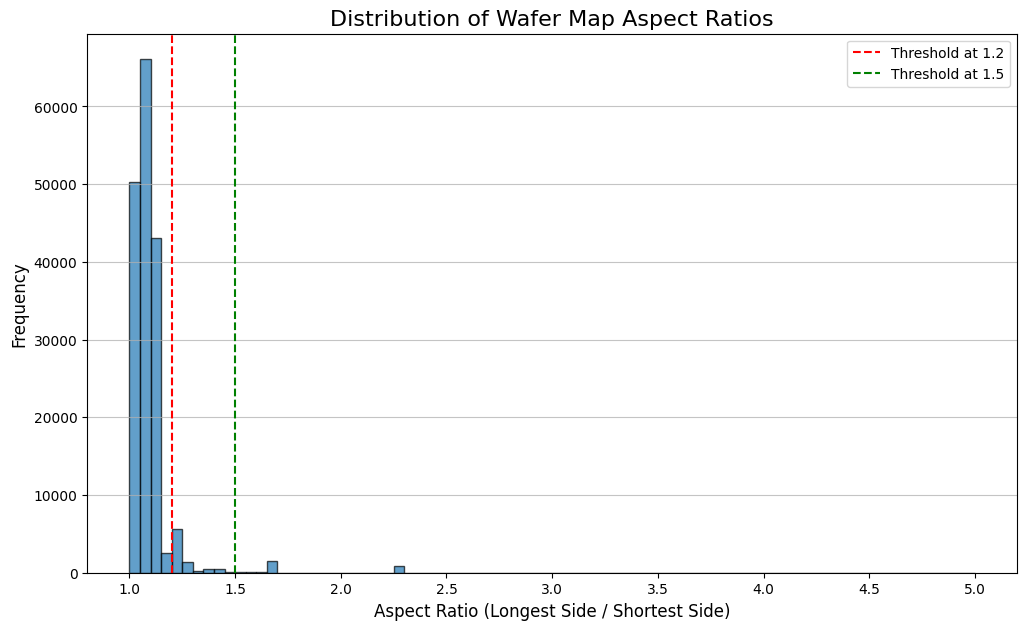

In [7]:
shapes = df_labeled['waferMap'].apply(lambda x: x.shape)

# Define aspect ratio as max(h, w) / min(h, w) so it's always >= 1
def get_aspect_ratio(shape):
    # Ensure shape is a tuple of two integers
    if not (isinstance(shape, tuple) and len(shape) == 2):
        return np.nan # Return NaN for invalid shapes
    h, w = shape
    if h == 0 or w == 0:
        return 1.0 # Avoid division by zero for empty or 1D maps, treat as square
    return max(h, w) / min(h, w)

# df_labeled['aspectRatio'] = shapes.apply(get_aspect_ratio)
df_labeled.loc[:, 'aspectRatio'] = shapes.apply(get_aspect_ratio)
# Drop any rows where aspect ratio could not be calculated
df_labeled.dropna(subset=['aspectRatio'], inplace=True)


# --- Analyze Distribution ---
print("\n--- Aspect Ratio Statistics ---")
print(df_labeled['aspectRatio'].describe())
print("\n")
print("Top 10 Most Common Aspect Ratios:")
print(df_labeled['aspectRatio'].value_counts().head(10))


# --- Visualize Distribution ---
plt.figure(figsize=(12, 7))
plt.hist(df_labeled['aspectRatio'], bins=80, edgecolor='black', alpha=0.7)
plt.title('Distribution of Wafer Map Aspect Ratios', fontsize=16)
plt.xlabel('Aspect Ratio (Longest Side / Shortest Side)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)

# Add vertical lines for potential thresholds to give context
plt.axvline(1.2, color='r', linestyle='--', linewidth=1.5, label='Threshold at 1.2')
plt.axvline(1.5, color='g', linestyle='--', linewidth=1.5, label='Threshold at 1.5')
plt.legend()
plt.show()

As you can see from the above plot, there are a couple wafers that have an usual aspect ratio. These need to be cleaned out of the data

Total number of labeled wafers: 172950
Found 4022 wafers with an aspect ratio of 1.3 or greater.
This is 2.33% of the labeled dataset.

Displaying a random sample of 10 of these outlier wafers:


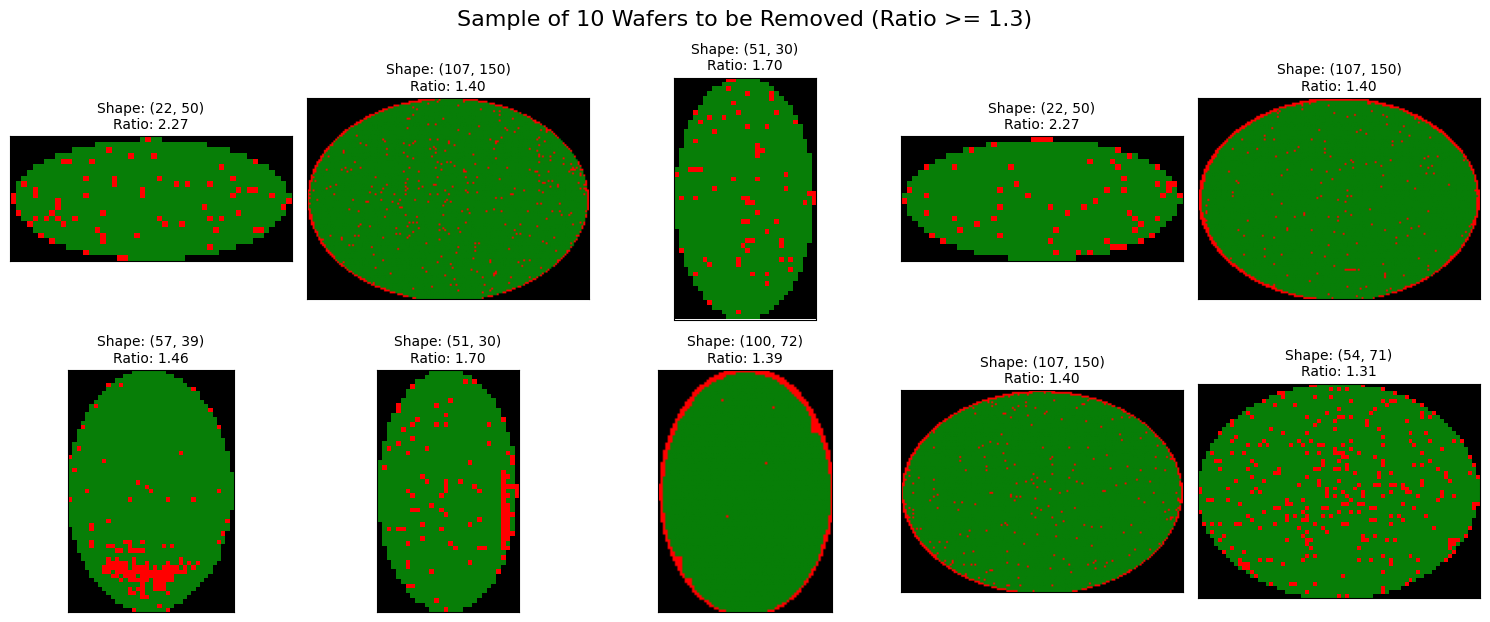

In [8]:
# --- Inspect Outliers ---
THRESHOLD = 1.3
df_outliers = df_labeled[df_labeled['aspectRatio'] >= THRESHOLD]

print(f"Total number of labeled wafers: {len(df_labeled)}")
print(f"Found {len(df_outliers)} wafers with an aspect ratio of {THRESHOLD} or greater.")
if len(df_labeled) > 0:
    print(f"This is {len(df_outliers)/len(df_labeled):.2%} of the labeled dataset.")

# --- Visualize a Sample of Outliers ---
if not df_outliers.empty:
    num_to_show = min(len(df_outliers), 10) # Show up to 10 examples
    sample_outliers = df_outliers.sample(n=num_to_show, random_state=42)

    print(f"\nDisplaying a random sample of {num_to_show} of these outlier wafers:")

    # Define a colormap from the original notebook
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(['black', "#077e07", 'red'])

    # Determine grid size
    ncols = 5
    nrows = (num_to_show + ncols - 1) // ncols # Calculate rows needed

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    axes = axes.flatten() # Flatten the array of axes for easy iteration

    for i, (idx, row) in enumerate(sample_outliers.iterrows()):
        wafer = row['waferMap']
        shape = wafer.shape
        ratio = row['aspectRatio']
        
        axes[i].imshow(wafer, cmap=cmap)
        axes[i].set_title(f"Shape: {shape}\nRatio: {ratio:.2f}", fontsize=10)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    # Hide any unused subplots
    for j in range(num_to_show, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle(f'Sample of {num_to_show} Wafers to be Removed (Ratio >= {THRESHOLD})', fontsize=16, y=1.03)
    plt.show()
else:
    print("\nNo wafers found above the specified threshold.")

Now we can filter out all the wafermaps with aspect ratio equal to or greater than 1.3

In [9]:
# Store the original count for verification
original_count = len(df_labeled)

# Filter the DataFrame and re-assign it to the same variable name.
# The .copy() is still recommended to ensure it's a new, clean dataframe.
df_labeled = df_labeled[df_labeled['aspectRatio'] < THRESHOLD]


# --- Verification ---
print("\n--- Verification ---")
print(f"Original number of wafers: {original_count}")
print(f"Number of wafers after filtering: {len(df_labeled)}")
print(f"Number of wafers removed: {original_count - len(df_labeled)}")


--- Verification ---
Original number of wafers: 172950
Number of wafers after filtering: 168928
Number of wafers removed: 4022



--- Verification ---
Original number of wafers: 168928
Example resized shape: (42, 42)


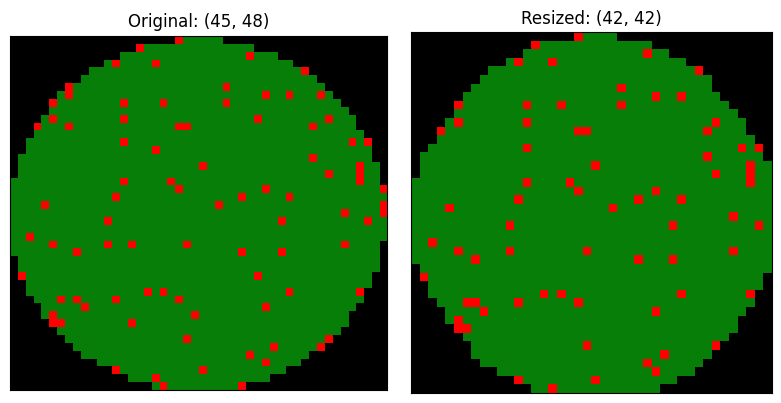

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# --- Settings ---
TARGET_SHAPE = (42, 42)
cmap = ListedColormap(['black', "#077e07", 'red'])  # same as before

# Store the original count for verification
original_count = len(df_labeled)

# --- Backup one wafer before resizing for plotting ---
example_index = 0  # change this if you want a different wafer
original_wafer = df_labeled["waferMap"].iloc[example_index]

# Function to resize wafer maps
def resize_wafer_map(wafer):
    return cv2.resize(wafer.astype(np.float32), TARGET_SHAPE, interpolation=cv2.INTER_NEAREST)

# Apply resizing to all wafers (overwrites waferMap)
df_labeled["waferMap"] = df_labeled["waferMap"].apply(resize_wafer_map)

# --- Verification ---
print("\n--- Verification ---")
print(f"Original number of wafers: {original_count}")
print(f"Example resized shape: {df_labeled['waferMap'].iloc[example_index].shape}")

# --- Plot before & after for the example wafer ---
resized_wafer = df_labeled["waferMap"].iloc[example_index]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(original_wafer, cmap=cmap)
axes[0].set_title(f"Original: {original_wafer.shape}")
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(resized_wafer, cmap=cmap)
axes[1].set_title(f"Resized: {resized_wafer.shape}")
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout()
plt.show()


In [11]:
# Split 85/15 
df_train, df_test = train_test_split(
    df_labeled,
    test_size=0.15,
    stratify=df_labeled["failureNum"],
    random_state=42
)

# Check the data types and non-null counts
print("Training Set")
print(df_train['failureType'].value_counts())
print("\nTesting Set")
print(df_test['failureType'].value_counts())

Training Set
failureType
[[none]]         123074
[[Edge-Ring]]      7652
[[Edge-Loc]]       4053
[[Center]]         3612
[[Loc]]            2935
[[Scratch]]         965
[[Random]]          726
[[Donut]]           444
[[Near-full]]       127
Name: count, dtype: int64

Testing Set
failureType
[[none]]         21720
[[Edge-Ring]]     1351
[[Edge-Loc]]       715
[[Center]]         637
[[Loc]]            518
[[Scratch]]        170
[[Random]]         128
[[Donut]]           79
[[Near-full]]       22
Name: count, dtype: int64


Downsampling None in testing set

In [13]:
# Number of "none" samples to keep
target_none_count = 2000

# Separate the "none" class and the others
df_none = df_test[df_test["failureType"] == "none"]
df_others = df_test[df_test["failureType"] != "none"]

# Randomly sample 2000 from "none"
df_none_downsampled = df_none.sample(n=target_none_count, random_state=42)

# Combine back together
df_test_balanced = pd.concat([df_none_downsampled, df_others], axis=0).reset_index(drop=True)

# Shuffle rows (optional but usually good practice)
df_test_balanced = df_test_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Original test dataset shape:", df_test.shape)
print("Balanced test dataset shape:", df_test_balanced.shape)
print(df_test_balanced["failureType"].value_counts())


Original test dataset shape: (25340, 7)
Balanced test dataset shape: (5620, 7)
failureType
[[none]]         2000
[[Edge-Ring]]    1351
[[Edge-Loc]]      715
[[Center]]        637
[[Loc]]           518
[[Scratch]]       170
[[Random]]        128
[[Donut]]          79
[[Near-full]]      22
Name: count, dtype: int64


In [16]:
# from skimage.transform import AffineTransform, warp

# # --- Targeted augmentation functions ---

# def augment_positional(wafer_map):
#     """Augmentation for positional patterns (Center, Edge-Loc, Edge-Ring, Loc)."""
#     augmented = []
#     augmented.append(np.fliplr(wafer_map))
#     augmented.append(np.flipud(wafer_map))
#     transform = AffineTransform(translation=(2, 2))
#     augmented.append(warp(wafer_map, transform, mode="edge"))
#     transform = AffineTransform(translation=(-2, -2))
#     augmented.append(warp(wafer_map, transform, mode="edge"))
#     return augmented

# def augment_scratch(wafer_map):
#     """Augmentation for Scratch defects (preserve line-like structure)."""
#     augmented = []
#     augmented.append(np.rot90(wafer_map, 1))
#     augmented.append(np.rot90(wafer_map, 2))
#     return augmented

# def augment_rare(wafer_map):
#     """Augmentation for rare classes (Donut, Near-full, Random)."""
#     augmented = []
#     for k in [1, 2, 3]:
#         augmented.append(np.rot90(wafer_map, k))
#     noise = wafer_map + np.random.choice([0, 1, 2], size=wafer_map.shape, p=[0.9, 0.09, 0.01])
#     augmented.append(np.clip(noise, 0, 2))
#     return augmented

# # --- Apply augmentation to dataset ---

# print("Original training data distribution:")
# print(df_train['failureType'].value_counts())

# # 1. Downsample "none" type wafers 
# df_none = df_train[df_train["failureNum"] == 8].sample(2000, random_state=42)

# # Get all other wafer types
# df_other_types = df_train[df_train["failureNum"] != 8]

# augmented_list = []

# # Loop over unique classes in the non-'none' dataframe
# for failure_num in df_other_types['failureNum'].unique():
#     class_df = df_other_types[df_other_types['failureNum'] == failure_num]
#     num_samples = len(class_df)
    
#     # Decide which augmenter to use
#     if failure_num in [0, 2, 3, 4]:   # Center, Edge-Loc, Edge-Ring, Loc
#         augmenter = augment_positional
#     elif failure_num == 6:            # Scratch
#         augmenter = augment_scratch
#     elif failure_num in [1, 5, 7]:    # Donut, Random, Near-full
#         augmenter = augment_rare
#     else:
#         augmenter = None
    
#     # Only augment if we have fewer than 2000 samples
#     if num_samples < 2000 and augmenter is not None:
#         num_to_generate = 2000 - num_samples
#         wafers_to_augment = class_df['waferMap'].values
#         generated_count = 0
        
#         while generated_count < num_to_generate:
#             wafer_to_augment = wafers_to_augment[np.random.randint(0, num_samples)]
#             augmented_wafers = augmenter(wafer_to_augment)
            
#             for wafer in augmented_wafers:
#                 if generated_count < num_to_generate:
#                     new_row = class_df.iloc[0].copy()
#                     new_row['waferMap'] = wafer
#                     augmented_list.append(new_row)
#                     generated_count += 1

# # Create a new dataframe with augmented samples
# df_augmented = pd.DataFrame(augmented_list)

# # Merge the downsampled 'none' wafers, the original other types, and the new augmented wafers
# df_train_augmented = pd.concat([df_none, df_other_types, df_augmented], ignore_index=True)

# print("Augmented training data distribution:")
# print(df_train_augmented['failureType'].value_counts())

from skimage.transform import AffineTransform, warp

TARGET_PER_CLASS = 2000  # Adjusted for a smaller dataset
RANDOM_STATE = 42

def augment_wafer_universal(wafer_map):
    """
    Applies a set of random transformations to a single wafer map.
    """
    augmented_wafer = wafer_map.copy()

    # Random Flips
    if np.random.rand() > 0.5:
        augmented_wafer = np.fliplr(augmented_wafer)
    if np.random.rand() > 0.5:
        augmented_wafer = np.flipud(augmented_wafer)

    # Random Affine Transformations
    rotation_angle = np.random.uniform(-10, 10)
    shear_angle = np.random.uniform(-0.1, 0.1)
    scale_factor = np.random.uniform(0.9, 1.1)
    shift_x = np.random.uniform(-0.1, 0.1) * wafer_map.shape[1]
    shift_y = np.random.uniform(-0.1, 0.1) * wafer_map.shape[0]

    transform = AffineTransform(
        scale=(scale_factor, scale_factor),
        rotation=np.deg2rad(rotation_angle),
        shear=shear_angle,
        translation=(shift_x, shift_y)
    )

    augmented_wafer = warp(augmented_wafer, transform.inverse, mode='edge', preserve_range=True)
    return augmented_wafer.astype(np.float32)

print("Original data distribution:")
print(df_train['failureType'].value_counts())
print("-" * 30)

balanced_list = []

for failure_num in df_train['failureNum'].unique():
    class_df = df_train[df_train['failureNum'] == failure_num]
    num_samples = len(class_df)

    if num_samples == 0:
        continue

    print(f"Processing class {class_df.iloc[0]['failureType']} ({num_samples} samples)...")

    # Downsample if over-represented
    if num_samples > TARGET_PER_CLASS:
        downsampled_df = class_df.sample(TARGET_PER_CLASS, random_state=RANDOM_STATE)
        balanced_list.append(downsampled_df)

    # Upsample with augmentation if under-represented
    elif num_samples < TARGET_PER_CLASS:
        num_to_generate = TARGET_PER_CLASS - num_samples
        balanced_list.append(class_df) # Add original samples

        generated_samples = []
        for _ in range(num_to_generate):
            original_wafer_row = class_df.sample(1).iloc[0]
            original_wafer = original_wafer_row['waferMap']
            new_wafer = augment_wafer_universal(original_wafer)
            
            new_row = original_wafer_row.copy()
            new_row['waferMap'] = new_wafer
            generated_samples.append(new_row)

        if generated_samples:
            balanced_list.append(pd.DataFrame(generated_samples))

    # If it's the correct size, just add it
    else:
        balanced_list.append(class_df)

df_train_augmented = pd.concat(balanced_list, ignore_index=True)

print("\nFinal augmented and balanced data distribution:")
print(df_train_augmented['failureType'].value_counts())
print("-" * 30)
print(f"Total samples after augmentation: {len(df_train_augmented)}")


Original data distribution:
failureType
[[none]]         123074
[[Edge-Ring]]      7652
[[Edge-Loc]]       4053
[[Center]]         3612
[[Loc]]            2935
[[Scratch]]         965
[[Random]]          726
[[Donut]]           444
[[Near-full]]       127
Name: count, dtype: int64
------------------------------
Processing class [['none']] (123074 samples)...
Processing class [['Edge-Loc']] (4053 samples)...
Processing class [['Random']] (726 samples)...
Processing class [['Edge-Ring']] (7652 samples)...
Processing class [['Scratch']] (965 samples)...
Processing class [['Loc']] (2935 samples)...
Processing class [['Center']] (3612 samples)...
Processing class [['Donut']] (444 samples)...
Processing class [['Near-full']] (127 samples)...

Final augmented and balanced data distribution:
failureType
[[none]]         2000
[[Edge-Loc]]     2000
[[Random]]       2000
[[Edge-Ring]]    2000
[[Scratch]]      2000
[[Loc]]          2000
[[Center]]       2000
[[Donut]]        2000
[[Near-full]]    

## 6. Data Exploration and Visualization

Let's visualize some of the wafer maps to get a feel for the data.

In [ ]:
# # Define a custom colormap
# # 0: background (black)
# # 1: good die (green)
# # 2: defective die (red)
# cmap = ListedColormap(['black', "#077e07", 'red'])

# num_to_show = 5

# unique_types = df_train["failureNum"].unique()   # includes 'none'

# fig, axes = plt.subplots(nrows=len(unique_types), ncols=num_to_show, figsize=(7,1.5*len(unique_types)))

# for row_idx, type in enumerate(unique_types):
#     # sample 5 wafers of this type
#     subset = df_train[df_train["failureNum"] == type].sample(n=num_to_show, random_state=69)

#     for col_idx, wafer in enumerate(subset["waferMap"]):
#         ax = axes[row_idx, col_idx]
#         ax.imshow(wafer, cmap=cmap)
#         ax.set_xticks([])
#         ax.set_yticks([])

#         if col_idx == 0:  # only label once per row
#             label = subset.failureType.iloc[0][0][0]  # first element of the first row
#             ax.set_title(label, fontsize=15, pad=5) 
# plt.tight_layout()
# plt.show()

## 7. Data Augmentation

After looking at the training data, there is a huge imbalance in failure types (68% of the data is just 'none'). This is where data augmentation comes into play.

Data augmentation is a crucial step to handle the imbalanced dataset. We can create new training samples from the minority classes by applying transformations like flipping and rotating.

Below are some functions to augment the wafer maps. These can be used to oversample the minority classes in the `df_train` DataFrame to create a more balanced dataset for training the model.

Visualization of the different sizes of the wafermaps. This will help decide what the input size of the data should be changed to in order to train

--- Frequency of Unique Wafer Map Sizes ---
     height  width  count
0        25     27   3421
1        26     26   1722
2        38     36   1695
3        39     37   1454
4        53     52   1236
..      ...    ...    ...
332      59     55      1
333      58     54      1
334      62     61      1
335      59     50      1
352      92     91      1

[353 rows x 3 columns]


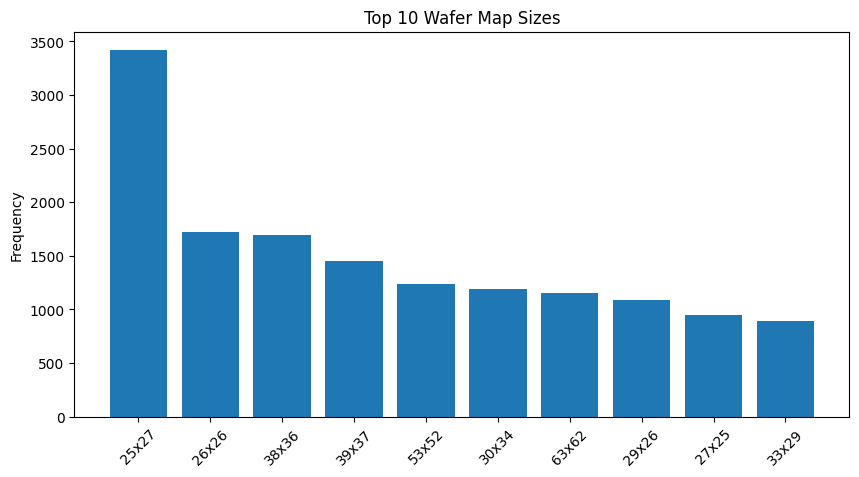

In [ ]:
# # Get the dimensions of each wafer map
# dims = df_train_augmented['waferMap'].apply(lambda x: x.shape)

# # Convert to a DataFrame of (height, width)
# dims_df = pd.DataFrame(dims.tolist(), columns=['height', 'width'])

# # Count frequency of each unique size
# size_counts = dims_df.value_counts().reset_index(name='count')
# size_counts = size_counts.sort_values(by='count', ascending=False)

# print("--- Frequency of Unique Wafer Map Sizes ---")
# print(size_counts)

# # Optional: plot the top 10 most common sizes
# top_sizes = size_counts.head(10)
# plt.figure(figsize=(10,5))
# plt.bar([f"{h}x{w}" for h, w in zip(top_sizes['height'], top_sizes['width'])],
#         top_sizes['count'])
# plt.xticks(rotation=45)
# plt.ylabel("Frequency")
# plt.title("Top 10 Wafer Map Sizes")
# plt.show()


## 8. Data Preparation for the Model

Now we will prepare the data for training. This involves:
1.  Separating features (X) and labels (y).
2.  Reshaping and normalizing the wafer map images.
3.  Splitting the augmented training data into training and validation sets.

Displaying 'before' and 'after' for wafers with different original sizes.


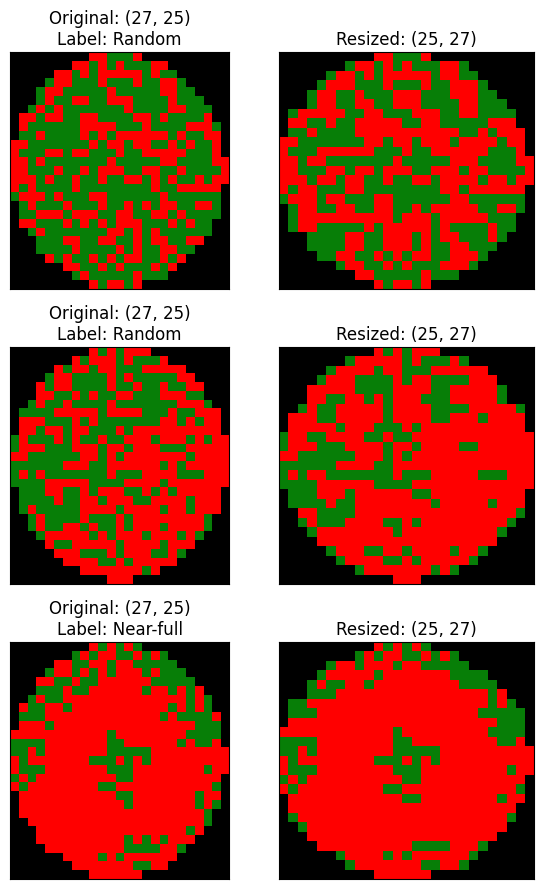

In [ ]:
# # --- Code to Visualize Wafer Resizing ---

# # Define the target size again just in case
# TARGET_SIZE = (25, 27)
# cmap = ListedColormap(['black', "#077e07", 'red'])

# # Find some wafers that are NOT the target size to use as examples
# non_target_size_df = df_train_augmented[df_train_augmented['waferMap'].apply(lambda x: x.shape != TARGET_SIZE)]

# if non_target_size_df.empty:
#     print(f"No wafers found with dimensions other than {TARGET_SIZE} to display.")
# else:
#     # Pick a few random examples from this subset
#     num_examples = 3
#     # Ensure we don't try to sample more examples than exist
#     sample_size = min(num_examples, len(non_target_size_df))
#     examples = non_target_size_df.sample(sample_size, random_state=42)

#     fig, axes = plt.subplots(nrows=sample_size, ncols=2, figsize=(6, 3 * sample_size))

#     # Handle the case where sample_size is 1, to prevent indexing errors
#     if sample_size == 1:
#         axes = np.array([axes])

#     print("Displaying 'before' and 'after' for wafers with different original sizes.")

#     for i in range(sample_size):
#         # Get the original wafer map and its properties
#         original_wafer = examples['waferMap'].iloc[i]
#         original_shape = original_wafer.shape

#         # Safely access the failure type label
#         try:
#             label = examples['failureType'].iloc[i][0][0]
#         except (IndexError, TypeError):
#             label = "Unknown"

#         # Resize the wafer just like in the preprocessing function
#         resized_wafer = resize(original_wafer, TARGET_SIZE, anti_aliasing=True)

#         # Plot the original wafer
#         ax1 = axes[i, 0]
#         ax1.imshow(original_wafer, cmap=cmap)
#         ax1.set_title(f"Original: {original_shape}\nLabel: {label}")
#         ax1.set_xticks([])
#         ax1.set_yticks([])

#         # Plot the resized wafer
#         ax2 = axes[i, 1]
#         ax2.imshow(resized_wafer, cmap=cmap)
#         ax2.set_title(f"Resized: {TARGET_SIZE}")
#         ax2.set_xticks([])
#         ax2.set_yticks([])

#     plt.tight_layout()
#     plt.show()

In [17]:
X_train_df = df_train_augmented[['waferMap']]
y_train_df = df_train_augmented['failureNum']

X_train_split, X_val_split, y_train, y_val = train_test_split(
    X_train_df,
    y_train_df,
    test_size=0.20,
    random_state=42,
    stratify=y_train_df
)

# --- Final Data Preparation for Model Input ---

def prepare_data_for_model(df):
    """
    Converts a DataFrame of preprocessed wafer maps into a 4D numpy array.
    """
    X = np.stack(df['waferMap'].values).astype('float32')
    X = X.reshape(-1, X.shape[1], X.shape[2], 1)
    return X

# Prepare the training, validation, and test datasets for the model
X_train = prepare_data_for_model(X_train_split)
X_val = prepare_data_for_model(X_val_split)

# Prepare the test set
X_test = prepare_data_for_model(df_test_balanced[['waferMap']])
y_test = df_test_balanced['failureNum']

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()


# Verify the final shapes
print("--- Final Dataset Shapes ---")
print(f'Training data shape: {X_train.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Validation data shape: {X_val.shape}')
print(f'Validation labels shape: {y_val.shape}')
print(f'Test data shape: {X_test.shape}')
print(f'Test labels shape: {y_test.shape}')

--- Final Dataset Shapes ---
Training data shape: (14400, 42, 42, 1)
Training labels shape: (14400,)
Validation data shape: (3600, 42, 42, 1)
Validation labels shape: (3600,)
Test data shape: (5620, 42, 42, 1)
Test labels shape: (5620,)


## 9. Model Training

Now we can train the model using our prepared training and validation data.

In [38]:
from keras.callbacks import EarlyStopping, LearningRateScheduler
from scipy import stats
from sklearn.utils import class_weight

# Define the Learning Rate Schedule Function
def lr_step_decay(epoch, lr):
     """
     Decays the learning rate in steps.
     Starts at 0.001, drops to 0.0005 after 5 epochs, then 0.00025 after 10 epochs.
     """
     initial_lr = 0.001
     drop_rate = 0.5  # Drop the LR by half
     epochs_drop = 5  # Drop it every 5 epochs

     new_lr = initial_lr * (drop_rate ** np.floor((1 + epoch) / epochs_drop))
     return new_lr

# Decreases learning rate dynamically
lr_scheduler = LearningRateScheduler(lr_step_decay, verbose=1)

# Calculate class weights to handle data imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

EPOCHS = 20
BATCH_SIZE = 32

# To avoid overtraining, we use an early stop if validation loss stops improving
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


y_train = y_train.astype('int32')
y_val = y_val.astype('int32')
y_test = y_test.astype('int32')

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler],
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 55s 114ms/step - accuracy: 0.5661 - loss: 1.2186 - val_accuracy: 0.3336 - val_loss: 2.4528 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.7322 - loss: 0.7307 - val_accuracy: 0.6672 - val_loss: 0.8969 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 51s 112ms/step - accuracy: 0.7779 - loss: 0.6185 - val_accuracy: 0.7322 - val_loss: 0.8838 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - accuracy: 0.8099 - loss: 0.5404 - val_accuracy: 0.7375 - val_loss: 0.6868 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0005.
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - ac

## 10. Visualize Training History

Plotting the model's accuracy and loss over epochs helps us understand the training process.

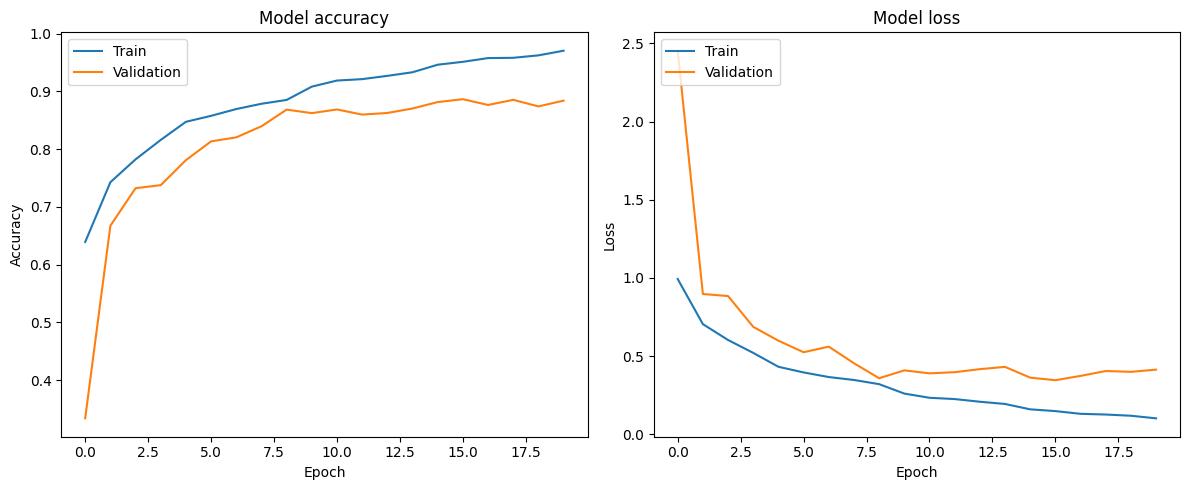

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## 11. Evaluate the Model

Let's evaluate the final model on the test set to see how well it generalizes to new, unseen data.

In [40]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.4465
Test Accuracy: 0.8619


### 11.2 Confusion Matrix

C:\Users\augus\AppData\Local\Temp\ipykernel_23604\4144917339.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test_balanced = df_test.groupby("failureNum", group_keys=False).apply(


Index(['waferMap', 'dieSize', 'trainTestLabel', 'failureType', 'failureNum',
       'trainTestNum', 'aspectRatio'],
      dtype='object')
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step
              precision    recall  f1-score   support

      Center       0.84      0.84      0.84       637
       Donut       0.72      0.70      0.71        79
    Edge-Loc       0.69      0.89      0.78       715
   Edge-Ring       0.98      0.96      0.97      1351
         Loc       0.70      0.58      0.63       518
      Random       0.89      0.93      0.91       128
     Scratch       0.61      0.68      0.64       170
   Near-full       1.00      1.00      1.00        22
        none       0.94      0.88      0.91      2000

    accuracy                           0.86      5620
   macro avg       0.82      0.83      0.82      5620
weighted avg       0.87      0.86      0.86      5620



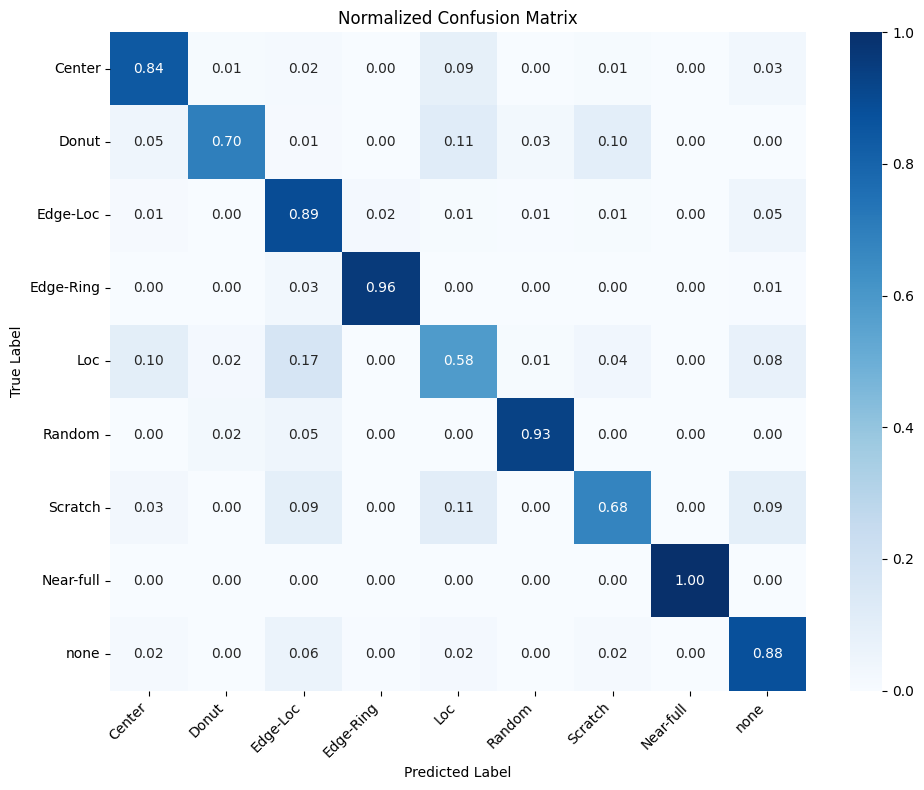

In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# To get the corresponding labels for each failure number
labels = [key for key, value in sorted(mapping_type.items(), key=lambda item: item[1])]

# Balancing the test data since most of it is just "None"
# Getting a max of 500 per class
df_test_balanced = df_test.groupby("failureNum", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 500), random_state=42)
).reset_index(drop=True)

print(df_test.columns)

# X_test_balanced, y_test_balanced = preprocess_wafers(df_test_balanced, TARGET_SIZE)

# Predict on test set
y_pred = model.predict(X_test).argmax(axis=1)

# Print per-class precision/recall/F1
print(classification_report(y_test, y_pred, target_names=labels))

# Confusion matrix (raw counts)
cm = confusion_matrix(y_test, y_pred)

# Normalize by row (true labels)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [29]:
# See the first 50 predictions vs labels
print("Predicted:", y_pred[:100])
print("True:", y_test[:100])

Predicted: [2 4 8 8 5 8 3 8 8 8 0 8 3 3 3 8 4 0 2 8 3 3 3 4 2 8 4 3 3 8 3 3 4 4 8 4 2
 0 3 2 8 4 2 6 8 4 0 8 2 8 8 8 8 3 3 8 8 3 2 6 8 3 3 4 3 8 8 8 3 8 8 3 0 3
 8 8 8 8 8 2 8 0 5 3 8 8 8 8 8 8 4 3 6 0 8 3 8 7 6 2]
True: [2 0 8 8 5 8 3 8 8 8 0 8 3 3 3 8 2 0 2 8 3 3 3 8 2 8 2 3 3 8 3 3 2 8 8 8 2
 0 3 2 8 4 4 6 8 4 0 8 2 8 8 8 8 3 3 8 8 3 2 2 8 3 3 2 3 8 8 8 3 8 8 3 0 3
 8 8 8 8 8 2 8 0 5 3 8 8 8 8 8 8 4 3 6 0 8 3 8 7 6 2]


## 12. Save the Trained Model

Finally, we'll save the trained model to a file so it can be loaded and used later without retraining.

In [ ]:
# model_dir = os.path.join('..', 'models')
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

# model_path = os.path.join(model_dir, 'wafer_defect_model.h5')
# model.save(model_path)
# print(f'Model saved to {model_path}')